In [1]:
%cd ..

/home/zarizky/projects/neural-autoregressive-object-co-occurrence


In [2]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import torch
from tqdm.auto import tqdm

from EinsumNetwork import EinsumNetwork, Graph
from utils.dataset import ObjectCooccurrenceCOCODataset

torch.manual_seed(0)
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
dataset_train = ObjectCooccurrenceCOCODataset("dataset/coco2017-cooccurences-train.csv")
dataset_valid = ObjectCooccurrenceCOCODataset("dataset/coco2017-cooccurences-valid.csv")

batch_size = 8196
dataloader_train = torch.utils.data.DataLoader(
    dataset_train,
    batch_size,
    True,
    drop_last=True,
    num_workers=8,
    pin_memory=device == "cuda",
)
dataloader_train2 = torch.utils.data.DataLoader(
    dataset_train, batch_size, num_workers=8, pin_memory=device == "cuda"
)
dataloader_valid = torch.utils.data.DataLoader(
    dataset_valid, batch_size, num_workers=8, pin_memory=device == "cuda"
)

In [4]:
max_num_epochs = 500
online_em_frequency = 1
online_em_stepsize = 1e-3
if dataloader_train.drop_last:
    online_em_stepsize = 1 / len(dataloader_train)

In [5]:
def create_region_graph(
    num_vars: int,
    num_repetition: int,
    max_depth: int,
    only_root_repetition: bool,
):
    region_graph = nx.DiGraph()

    ids = tuple(range(num_vars))
    root_node = Graph.DistributionVector(ids)
    split(
        num_vars,
        num_repetition,
        max_depth,
        only_root_repetition,
        region_graph,
        root_node,
    )

    return region_graph


def split(
    num_vars: int,
    num_repetition: int,
    max_depth: int,
    only_root_repetition: bool,
    region_graph: nx.DiGraph,
    root_node: Graph.DistributionVector,
):
    ids = root_node.scope

    if len(ids) <= 1 or max_depth <= 0:
        return

    if only_root_repetition and len(ids) < num_vars:
        num_repetition = 1

    for repetition in range(num_repetition):
        ids = np.random.permutation(ids)

        splits = np.array_split(ids, 2)

        product_node = Graph.Product(ids)
        region_graph.add_edge(root_node, product_node)
        for s in splits:
            split_node = Graph.DistributionVector(s)
            split_node.einet_address.replica_idx = repetition
            region_graph.add_edge(product_node, split_node)

            split(
                num_vars,
                num_repetition,
                max_depth - 1,
                only_root_repetition,
                region_graph,
                split_node,
            )

In [6]:
def rat_spn_graph(num_vars: int, num_repetition: int, max_depth: int):
    """
    EiNet RAT-SPN structure simplified implementation for EiNet (Peharz et al., 2020)
    """

    region_graph = nx.DiGraph()

    ids = tuple(range(num_vars))
    root_node = Graph.DistributionVector(ids)

    for repetition in range(num_repetition):
        rsplit(region_graph, root_node, max_depth, repetition)

    return region_graph


def rsplit(
    region_graph: nx.DiGraph,
    root_node: Graph.DistributionVector,
    max_depth: int,
    replica_idx: int,
):
    if max_depth <= 0:
        return

    if len(root_node.scope) <= 1:
        raise RuntimeWarning("Stopping split, root node have only one variable.")
        return

    ids = np.random.permutation(root_node.scope)
    splits = np.array_split(ids, 2)

    product_node = Graph.Product(ids)
    region_graph.add_edge(root_node, product_node)

    for split in splits:
        split_node = Graph.DistributionVector(split)
        split_node.einet_address.replica_idx = replica_idx

        region_graph.add_edge(product_node, split_node)

        rsplit(region_graph, split_node, max_depth - 1, replica_idx)

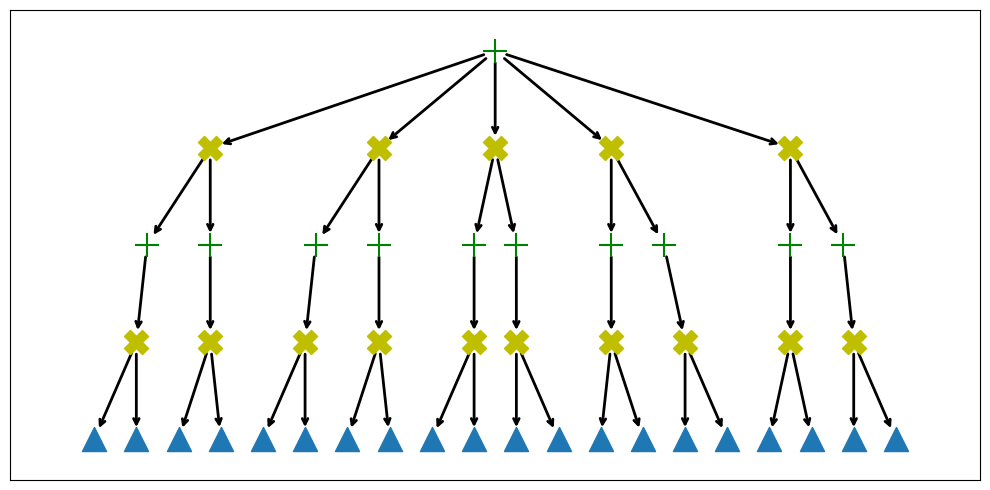

In [7]:
num_vars = dataset_train.features.shape[-1]
num_repetition = 5
max_depth = 2
num_distributions = 1

RG = rat_spn_graph(num_vars, num_repetition, max_depth)

distributions = Graph.get_leaves(RG)
products = Graph.get_products(RG)
sums = Graph.get_sums(RG)

fig = plt.figure(figsize=(10, 5))
layout = nx.nx_agraph.graphviz_layout(RG, prog="dot")
nx.draw_networkx_nodes(RG, layout, distributions, node_shape="^")
nx.draw_networkx_nodes(RG, layout, products, node_shape="X", node_color="y")
nx.draw_networkx_nodes(RG, layout, sums, node_shape="+", node_color="g")
nx.draw_networkx_edges(RG, layout, arrowstyle="->", arrowsize=10, width=2)
fig.tight_layout()

In [8]:
args = EinsumNetwork.Args(
    num_classes=1,
    num_input_distributions=num_distributions,
    exponential_family=EinsumNetwork.CategoricalArray,
    exponential_family_args={"K": 29},
    num_sums=num_distributions,
    num_var=dataset_train.features.shape[1],
    online_em_frequency=online_em_frequency,
    online_em_stepsize=online_em_stepsize,
)

einet = EinsumNetwork.EinsumNetwork(RG, args)
einet.initialize()
einet.to(device)
print(einet)
print("Model size:\t{:,}".format(sum(p.numel() for p in einet.parameters())))

EinsumNetwork(
  (einet_layers): ModuleList(
    (0): FactorizedLeafLayer(
      (ef_array): CategoricalArray()
    )
    (1-2): 2 x EinsumLayer()
    (3): EinsumMixingLayer()
  )
)
Model size:	11,620


In [9]:
for p in einet.parameters():
    print(p.size())

torch.Size([80, 1, 5, 29])
torch.Size([1, 1, 1, 10])
torch.Size([1, 1, 1, 5])
torch.Size([1, 1, 5])


In [10]:
for epoch_count in (pbar := tqdm(range(1, max_num_epochs + 1), unit="epoch")):
    # evaluate
    train_ll = 0
    valid_ll = 0

    for inputs in dataloader_train:
        inputs = inputs.to(device)
        outputs = einet.forward(inputs)

        ll_sample = EinsumNetwork.log_likelihoods(outputs)
        log_likelihood = ll_sample.sum()

        objective = log_likelihood
        objective.backward()
        einet.em_process_batch()
        einet.em_update()
        einet.zero_grad()

    with torch.inference_mode():
        for inputs in dataloader_train2:
            inputs = inputs.to(device)
            outputs = einet.forward(inputs)

            ll_sample = EinsumNetwork.log_likelihoods(outputs)
            log_likelihood = ll_sample.sum()

            train_ll = train_ll + log_likelihood.item()

        for inputs in dataloader_valid:
            inputs = inputs.to(device)
            outputs = einet.forward(inputs)

            ll_sample = EinsumNetwork.log_likelihoods(outputs)
            log_likelihood = ll_sample.sum()

            valid_ll = valid_ll + log_likelihood.item()

    pbar.set_postfix_str(
        "Train NLL {:.4f}\tValid NLL {:.4f}".format(
            -train_ll / len(dataset_train),
            -valid_ll / len(dataset_valid),
        )
    )

  0%|          | 0/500 [00:00<?, ?epoch/s]